In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [3]:
raw_data = pd.read_table('user_taggedbookmarks-timestamps.dat')

In [38]:
df = raw_data.dropna()
raw_data.head()

,userID,bookmarkID,tagID,timestamp
0,8,1,1,1289255362000
1,8,2,1,1289255159000
2,8,7,1,1289238901000
3,8,7,6,1289238901000
4,8,7,7,1289238901000


In [40]:
df['userID'] = df['userID'].astype(str)
df['bookmarkID'] = df['bookmarkID'].astype(str)                   


df

,userID,bookmarkID,tagID,timestamp
0,8,1,1,1289255362000
1,8,2,1,1289255159000
2,8,7,1,1289238901000
3,8,7,6,1289238901000
4,8,7,7,1289238901000
...,...,...,...,...
437588,108035,30993,193,1277495315000
437589,108035,30993,673,1277495315000
437590,108035,30994,130,1277223715000
437591,108035,30994,267,1277223715000


In [41]:
df['User+Bookmark'] = df['userID']+' '+df['bookmarkID']
df

,userID,bookmarkID,tagID,timestamp,User+Bookmark
0,8,1,1,1289255362000,8 1
1,8,2,1,1289255159000,8 2
2,8,7,1,1289238901000,8 7
3,8,7,6,1289238901000,8 7
4,8,7,7,1289238901000,8 7
...,...,...,...,...,...
437588,108035,30993,193,1277495315000,108035 30993
437589,108035,30993,673,1277495315000,108035 30993
437590,108035,30994,130,1277223715000,108035 30994
437591,108035,30994,267,1277223715000,108035 30994


In [42]:
df2 = df.groupby('User+Bookmark')[['tagID']].count()
df2

,tagID
User+Bookmark,
100111 14299,6
100111 22339,3
100111 22340,3
100111 22341,3
100111 22342,3
...,...
9985 21337,4
9985 21340,3
9985 573,3


In [44]:
df2['User+Bookmark'] = df2.index
df = pd.concat([df2['User+Bookmark'].str.split(' ', expand=True)], axis=1)
df

,0,1
User+Bookmark,,
100111 14299,100111,14299
100111 22339,100111,22339
100111 22340,100111,22340
100111 22341,100111,22341
100111 22342,100111,22342
...,...,...
9985 21337,9985,21337
9985 21340,9985,21340
9985 573,9985,573


In [65]:
df3 = df.join(df2, on='User+Bookmark')
df3.columns = ['UserID', 'BookmarkID', 'TagID', 'User+Bookmark']
df3 = df3.drop(['User+Bookmark'], axis='columns')

In [68]:
print(df3)

               UserID BookmarkID  TagID
User+Bookmark                          
100111 14299   100111      14299      6
100111 22339   100111      22339      3
100111 22340   100111      22340      3
100111 22341   100111      22341      3
100111 22342   100111      22342      3
...               ...        ...    ...
9985 21337       9985      21337      4
9985 21340       9985      21340      3
9985 573         9985        573      3
9985 6771        9985       6771      5
9985 6848        9985       6848      3

[104799 rows x 3 columns]


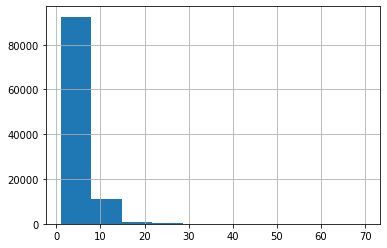

In [75]:
df3.iloc[np.where(df3.TagID < 100)].TagID.hist()

In [78]:
df3['User_id'] = df3['UserID'].astype("category").cat.codes
df3['Bookmark_id'] = df3['BookmarkID'].astype("category").cat.codes

In [79]:
data = df3.drop(['UserID', 'BookmarkID'], axis=1)

In [80]:
users = list(np.sort(data.User_id.unique()))
bookmarkss = list(np.sort(data.Bookmark_id.unique()))
tags = list(data.TagID)

In [81]:
rows = data.User_id.astype(int)
cols = data.Bookmark_id.astype(int)

In [83]:
data_sparse = sparse.csr_matrix((tags, (cols, rows)), shape=(len(bookmarkss), len(users)))

In [84]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

In [85]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [86]:
recommendations

[(50551, 0.30893755),
 (5650, 0.30529425),
 (5699, 0.3028661),
 (60277, 0.2919461),
 (7720, 0.29155755),
 (7686, 0.28641486),
 (13947, 0.28097415),
 (5646, 0.2752919),
 (13952, 0.27186686),
 (41578, 0.2710014)]

In [91]:
item_lookup = df3[['Bookmark_id', 'BookmarkID']].drop_duplicates()
item_lookup['Bookmark_id'] = item_lookup.Bookmark_id.astype(str)

Bookmark_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    Bookmark_id_name[row.Bookmark_id] = row.BookmarkID

for r in recommendations:
    print(Bookmark_id_name[str(r[0])])


7350
11530
11584
8726
14216
14154
22423
11527
22431
607


In [92]:
itemid = 5
related = model.similar_items(itemid)

In [93]:
related

[(69181, 0.18729411),
 (69219, 0.18729411),
 (69222, 0.18729411),
 (69190, 0.1872941),
 (69167, 0.1872941),
 (69168, 0.1872941),
 (69178, 0.1872941),
 (69182, 0.1872941),
 (69199, 0.1872941),
 (69156, 0.1872941)]

In [96]:
Bookmark_id_name['5']

'100003'

In [97]:
for a in related:
    print(Bookmark_id_name[str(a[0])])

99948
99995
99999
99957
99930
99931
99945
99949
99969
99919
